In [97]:
from collections import Counter, defaultdict
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings

In [98]:
class PlateFillError(Exception):
    def __init__(self, message):
        self.message = message
        super().__init__(self.message)

class PlateFiller:
    def __init__(self, plate_size, samples, reagents, replicas, number_of_plates):
        self.validate_inputs(plate_size, samples, reagents, replicas, number_of_plates)
        self.plate_size = plate_size
        self.number_of_rows, self.number_of_columns = self.get_plate_dimensions()
        self.samples = samples
        self.reagents = reagents
        self.replicas = replicas
        self.number_of_plates = number_of_plates
        self.check_if_enough_plates()
        self.plates = []
        self.colors = mcolors.TABLEAU_COLORS
        self.color_cycle = itertools.cycle(self.colors)
        self.color_map = {}

    def validate_inputs(self, plate_size, samples, reagents, replicas, number_of_plates):
        self.validate_plate_size(plate_size)
        self.validate_samples(samples)
        self.validate_reagents(reagents)
        self.validate_replicas(replicas)
        self.validate_number_of_plates(number_of_plates)
        self.validate_number_of_experiments(samples, reagents, replicas)
        
    def validate_plate_size(self, plate_size):
        if not isinstance(plate_size, int):
            raise ValueError(f"Invalid plate size input. Expected an integer, but got {type(plate_size)}.")
        if plate_size not in [96, 384]:
            raise ValueError(f"Invalid plate size {plate_size}. Expected 96 or 384.")

    def validate_samples(self, samples):
        if not isinstance(samples, list) or not samples:
            raise ValueError("Samples should be a list of lists of strings.")
        for sample_list in samples:
            if not isinstance(sample_list, list):
                raise ValueError("Each element of samples should be a list of strings.")
            if len(sample_list) != len(set(sample_list)):
                raise ValueError("An experiment has reoccuring samples, please validate the input. Sample duplication is not allowed within the experiments.")
            for sample in sample_list:
                if not isinstance(sample, str):
                    raise ValueError(f"Expected a string sample, but got {type(sample)} instead.")
                
    def validate_reagents(self, reagents):
        if not isinstance(reagents, list) or not reagents:
            raise ValueError("Reagents should be a list of lists of strings.")
        for reagent_list in reagents:
            if not isinstance(reagent_list, list):
                raise ValueError("Each element of reagents should be a list of strings.")
            if len(reagent_list) != len(set(reagent_list)):
                raise ValueError("An experiment has reoccuring reagents, please validate the input. Reagent duplication is not allowed within the experiments.") # Not a requirement, but seems sensible.
            for reagent in reagent_list:
                if not isinstance(reagent, str):
                    raise ValueError(f"Expected a string reagent, but got {type(reagent)} instead.")

    def validate_replicas(self, replicas):
        if not isinstance(replicas, list) or not replicas:
            raise ValueError("Replicas should be a list of integers.")
        for replica in replicas:
            if not isinstance(replica, int):
                raise ValueError(f"Expected a integer replica, but got {type(replica)} instead.")
            if replica <= 0:
                raise ValueError(f"Replica has to be an integer greater than 0, but got {replica}.")
            
    def validate_number_of_plates(self, number_of_plates):
        if not isinstance(number_of_plates, int):
            raise ValueError(f"Invalid number of plates input. Expected an integer, but got {type(number_of_plates)}.")
        if number_of_plates <= 0:
            raise ValueError(f"Number of plates has to be a non-negative integer, but got {number_of_plates}.")
    
    def validate_number_of_experiments(self, samples, reagents, replicas):
        if len(samples) != len(reagents) or len(reagents) != len(replicas):
            raise ValueError(f"Number of experiments is not consistent length of samples: {len(samples)}, length of reagents: {len(reagents)}, length of replicas: {len(replicas)}.")

    def get_plate_dimensions(self):
        if self.plate_size == 96:
            num_rows = 8
            num_cols = 12
        elif self.plate_size == 384:
            num_rows = 16
            num_cols = 24
        return num_rows, num_cols
    
    def check_if_enough_plates(self):
        wells_available = self.plate_size * self.number_of_plates
        wells_needed = 0
        experiment_count = len(self.replicas)
        for experiment_number in range(experiment_count):
            wells_needed += len(self.samples[experiment_number]) * len(self.reagents[experiment_number]) * self.replicas[experiment_number]
        if wells_needed > wells_available:
            error_message = f"Number of wells needed {wells_needed} exceed available number of wells {wells_available}."
            raise PlateFillError(error_message)
    
    # Compare both microplate plans, prefer grouped reagents over grouped samples
    def evaluate_microplate_penalty(self, plates):
        penalty = 0
        for plate in plates:
            previous_sample, previous_reagent = plate[0][0]
            for row in plate:
                for well in row:
                    if any(well):
                        current_sample, current_reagent = well
                        if current_sample != previous_sample:
                            penalty += 1
                            previous_sample = current_sample
                        if current_reagent != previous_reagent:
                            penalty += 1.5
                            previous_reagent = current_reagent
        return penalty
    
    def create_empty_plate(self):
        return [[[None] for _ in range(self.number_of_columns)] for _ in range(self.number_of_rows)]

    def fill_plates(self, plate, items):
        current_well = 0
        plates = []
        for sample, reagent in items:
            if current_well == self.plate_size:
                plates.append(plate)
                plate = self.create_empty_plate()
                current_well = 0
            row_index = current_well // self.number_of_columns
            column_index = current_well % self.number_of_columns
            plate[row_index][column_index] = [sample, reagent]
            current_well += 1
        if plate:
            plates.append(plate)
        return plates

    def group_related_experiments(self):
        samples_per_reagent_counter = defaultdict(Counter)
        reagents_per_sample_counter = defaultdict(Counter)
        reagent_counter = Counter()
        sample_counter = Counter()

        for exp_samples, exp_reagents, exp_replicas in zip(self.samples, self.reagents, self.replicas):
            for reagent in exp_reagents:
                for sample in exp_samples:
                    samples_per_reagent_counter[reagent][sample] += exp_replicas
                    reagents_per_sample_counter[sample][reagent] += exp_replicas
                    sample_counter[sample] += exp_replicas
                    reagent_counter[reagent] += exp_replicas

        plate = self.create_empty_plate()
        items_by_reagent = []
        for reagent in reagent_counter:
            for sample, freq in sorted(samples_per_reagent_counter[reagent].most_common()):
                for _ in range(freq):
                    items_by_reagent.append([sample, reagent])
        group_by_reagent_result = self.fill_plates(plate, items_by_reagent)

        plate = self.create_empty_plate()
        items_by_sample = []
        for sample in sample_counter:
            for reagent, freq in sorted(reagents_per_sample_counter[sample].most_common()):
                for _ in range(freq):
                    items_by_sample.append([sample, reagent])    
        group_by_sample_result = self.fill_plates(plate, items_by_sample)

        self.plates = group_by_reagent_result if self.evaluate_microplate_penalty(group_by_sample_result) >= self.evaluate_microplate_penalty(group_by_reagent_result) else group_by_sample_result
    
    def plot_plates(self):
        if not self.plates:
            warnings.warn("No plates to display. Try calling group_related_experiments first.")
            return
        for i, plate in enumerate(self.plates, 1):
            self.plot_plate(plate=plate, color_by='reagent', plate_index=i)
            if i == 5: break
        for i, plate in enumerate(self.plates, 1):
            self.plot_plate(plate=plate, color_by='sample', plate_index=i)
            if i == 5: break

    def plot_plate(self, plate, color_by, plate_index):
        figsize = (self.number_of_rows, self.number_of_columns)
        
        _, ax = plt.subplots(figsize=figsize)
        
        title_text = f"Colored by {color_by.capitalize()}"
        if plate_index is not None:
            title_text += f" | Plate Index: {plate_index}"
        plt.title(title_text)
        
        for i, row in enumerate(plate):
            for j, well in enumerate(row):
                if all(w is not None for w in well):
                    item_to_color = well[0] if color_by == 'sample' else well[1]
                    
                    if item_to_color not in self.color_map:
                        self.color_map[item_to_color] = next(self.color_cycle)
                    
                    ax.text(j, i, f"{well[0]}\n{well[1]}", ha='center', va='center', fontsize=8, color='black')
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor=self.color_map[item_to_color], edgecolor='black', linewidth=2))
                else:
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor='white', edgecolor='black', linewidth=2))
        
        row_labels = [chr(i) for i in range(ord('A'), ord('A') + self.number_of_rows)]
        col_labels = [i + 1 for i in range(self.number_of_columns)]

        for i, label in enumerate(row_labels):
            ax.text(-1, i, label, ha='center', va='center', fontsize=8, color='black')

        for j, label in enumerate(col_labels):
            ax.text(j, -1, str(label), ha='center', va='center', fontsize=8, color='black')

        ax.set_xlim(-0.5, len(plate[0])-0.5)
        ax.set_ylim(-0.5, len(plate)-0.5)
        ax.set_aspect('equal', 'box')
        plt.gca().invert_yaxis()
        plt.axis('off')
        plt.show()

In [99]:
# Example where there are far fewer samples than reagents
plate_size = 96
samples = [['Sam 1'],['Sam 1', 'Sam 2', 'Sam 5'],['Sam 3','Sam 5']]
reagents = [['Reag X'], ['Reag ' + chr(ord('A') + i) for i in range(12)],['Reag ' + chr(ord('a') + i) for i in range(12)]]
replicas = [1,2,2]
number_of_plates = 3

try:
    plate_filler = PlateFiller(plate_size=plate_size, samples=samples, reagents=reagents, replicas=replicas, number_of_plates=number_of_plates)
    plate_filler.plot_plates()

except Exception as e:
    raise

C:\Users\rmarko\AppData\Local\Temp\ipykernel_16080\3142501409.py:167: UserWarning: No plates to display. Try calling group_related_experiments first.
  warnings.warn("No plates to display. Try calling group_related_experiments first.")


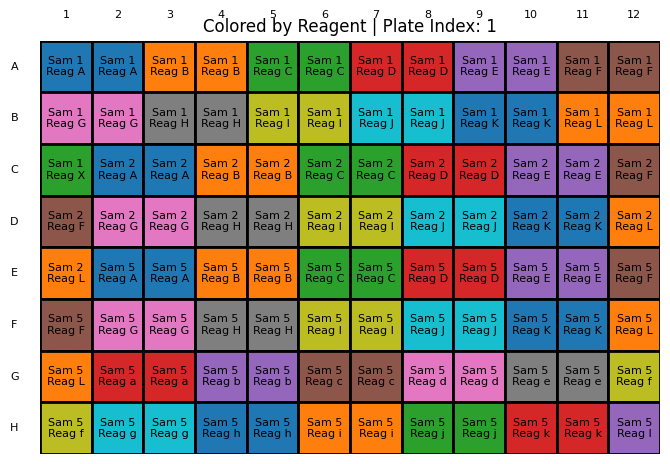

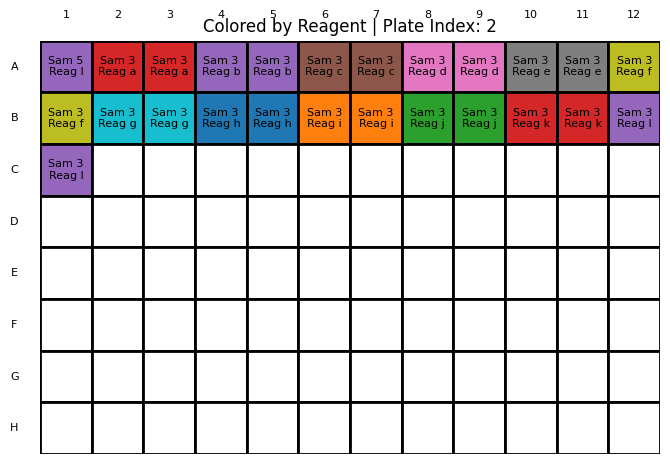

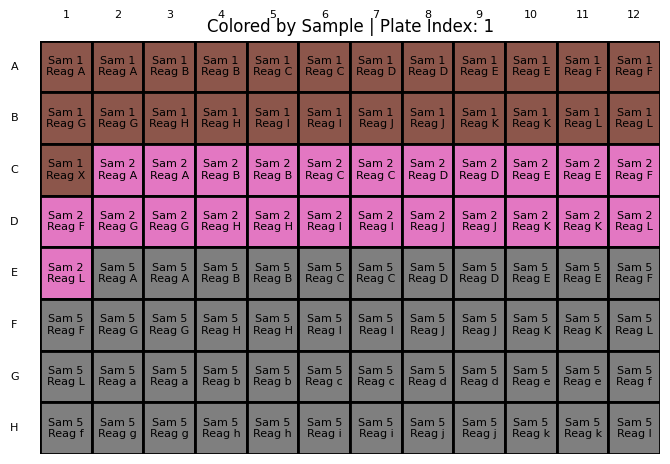

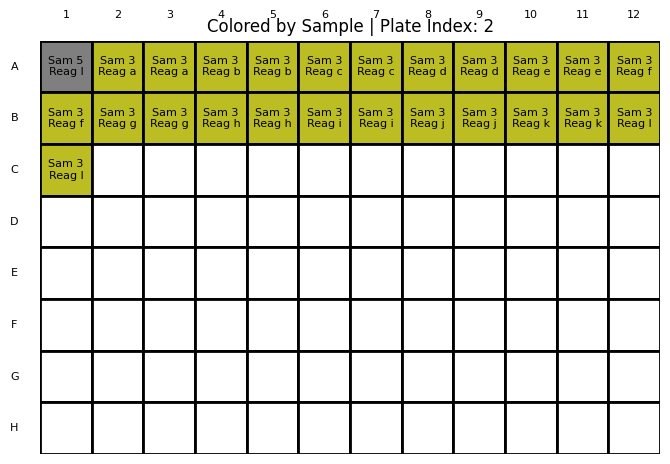

In [100]:
# Example where there are far fewer samples than reagents
plate_size = 96
samples = [['Sam 1'],['Sam 1', 'Sam 2', 'Sam 5'],['Sam 3','Sam 5']]
reagents = [['Reag X'], ['Reag ' + chr(ord('A') + i) for i in range(12)],['Reag ' + chr(ord('a') + i) for i in range(12)]]
replicas = [1,2,2]
number_of_plates = 3

try:
    plate_filler = PlateFiller(plate_size=plate_size, samples=samples, reagents=reagents, replicas=replicas, number_of_plates=number_of_plates)
    plate_filler.group_related_experiments()
    plate_filler.plot_plates()

except Exception as e:
    raise

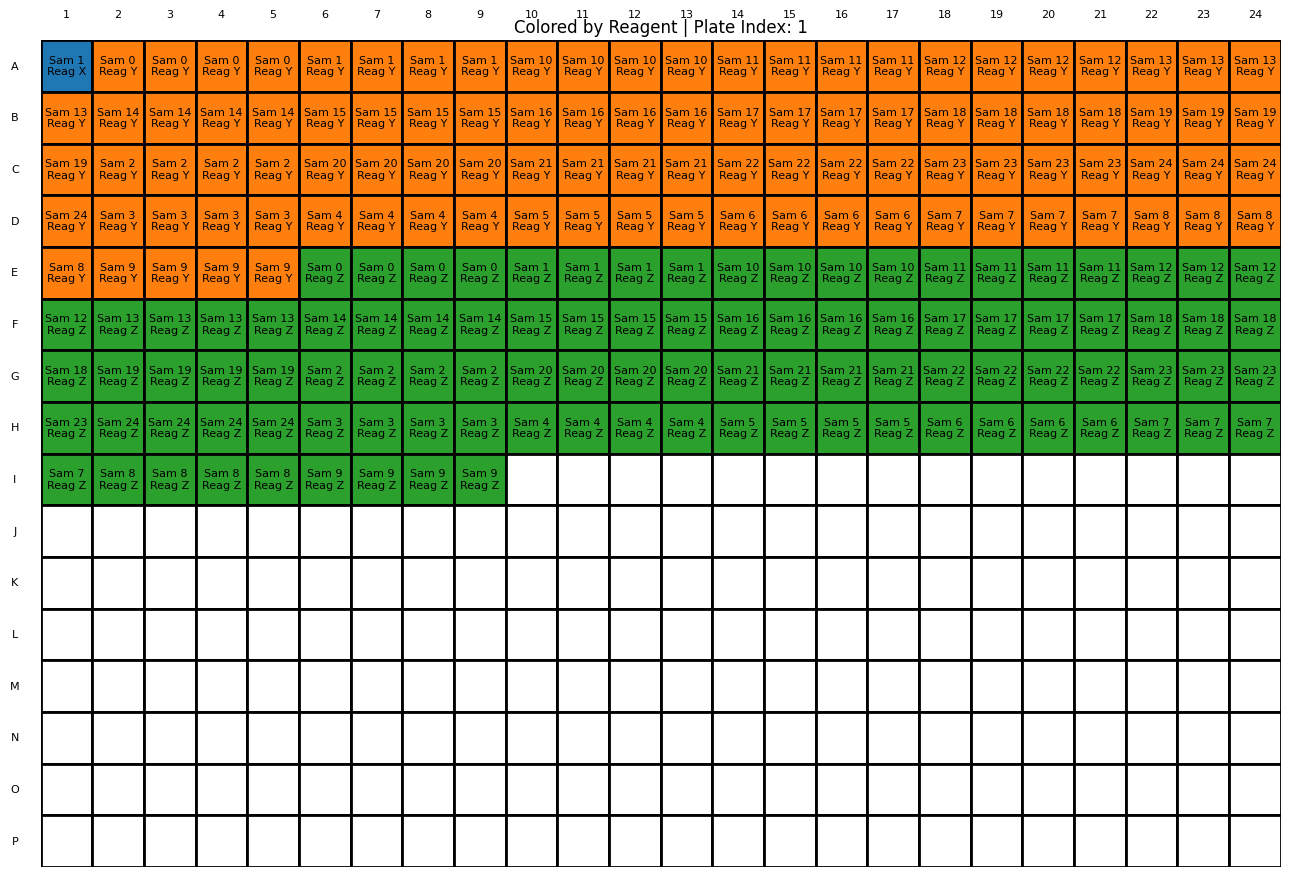

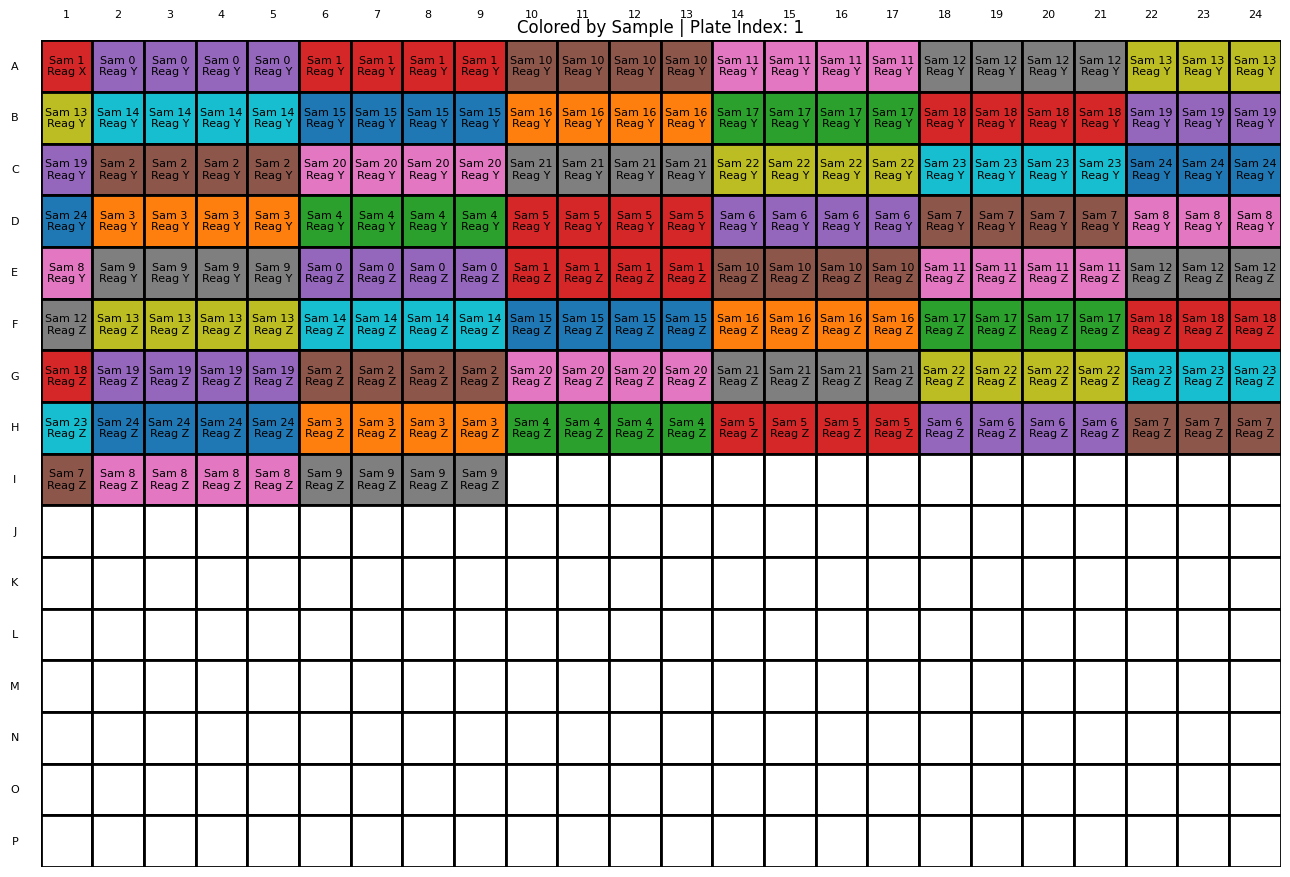

In [101]:
# Example where there are far fewer reagents than samples
plate_size = 384
samples = [['Sam 1'],['Sam ' + str(i) for i in range(25)]]
reagents = [['Reag X'],['Reag Y', 'Reag Z']]
replicas = [1,4]
number_of_plates = 3

try:
    plate_filler = PlateFiller(plate_size=plate_size, samples=samples, reagents=reagents, replicas=replicas, number_of_plates=number_of_plates)
    plate_filler.group_related_experiments()
    plate_filler.plot_plates()
except Exception as e:
    raise

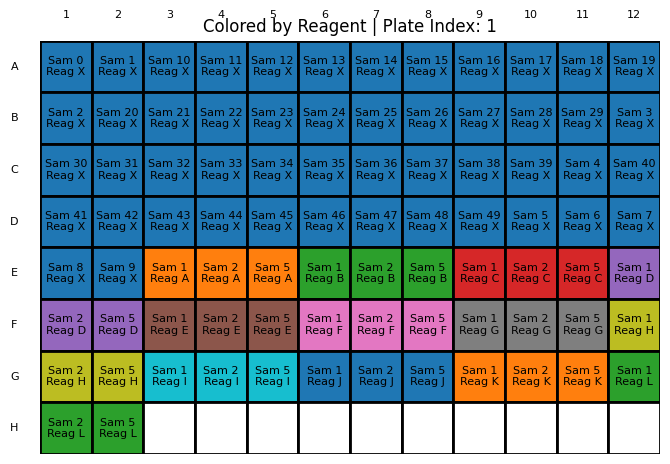

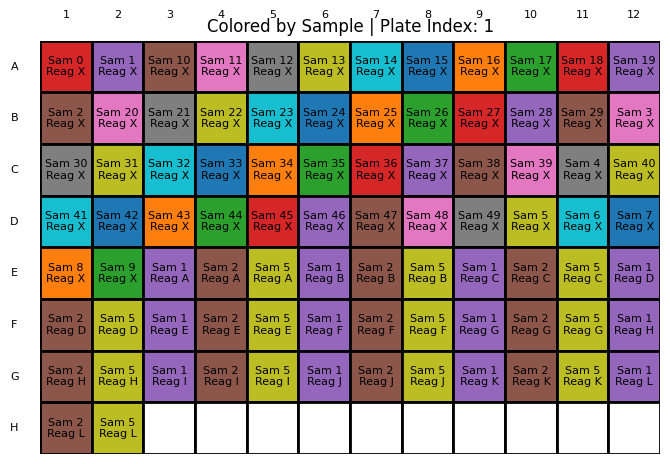

In [102]:
# Example where there are far fewer samples than reagents
plate_size = 96
samples = [['Sam ' + str(i) for i in range(50)],['Sam 1', 'Sam 2', 'Sam 5']]
reagents = [['Reag X'], ['Reag ' + chr(ord('A') + i) for i in range(12)]]
replicas = [1,1]
number_of_plates = 3

try:
    plate_filler = PlateFiller(plate_size=plate_size, samples=samples, reagents=reagents, replicas=replicas, number_of_plates=number_of_plates)
    plate_filler.group_related_experiments()
    plate_filler.plot_plates()

except Exception as e:
    raise

In [103]:
# Too many experiments example
plate_size = 96
samples = [['Sam 1'],['Sam 1', 'Sam 2', 'Sam 5'],['Sam 3','Sam 5']]
reagents = [['Reag X'], ['Reag ' + chr(ord('A') + i) for i in range(25)],['Reag ' + chr(ord('a') + i) for i in range(25)]]
replicas = [1,2,2]
number_of_plates = 1

try:
    plate_filler = PlateFiller(plate_size=96, samples=samples, reagents=reagents, replicas=replicas, number_of_plates=number_of_plates)
    plate_filler.group_related_experiments()
except Exception as e:
    raise

PlateFillError: Number of wells needed 251 exceed available number of wells 96.